In [276]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

In [277]:
#Reading the data
training_data = loadmat('dados_treinamento.mat')
test_data = loadmat('dados_teste.mat')
validation_data = loadmat('dados_val.mat')

In [278]:
#Separating the X and Y
y_training = training_data['y']
x_training = training_data['X']

y_test = test_data['yt']
x_test = test_data['Xt']

y_validation = validation_data['yval']
x_validation = validation_data['Xval']

print("Training data shape: " + str(x_training.shape))
print("Validation data shape: " + str(x_validation.shape))
print("Test data shape: " + str(x_test.shape))

Training data shape: (1000, 2)
Validation data shape: (1000, 2)
Test data shape: (1000, 2)


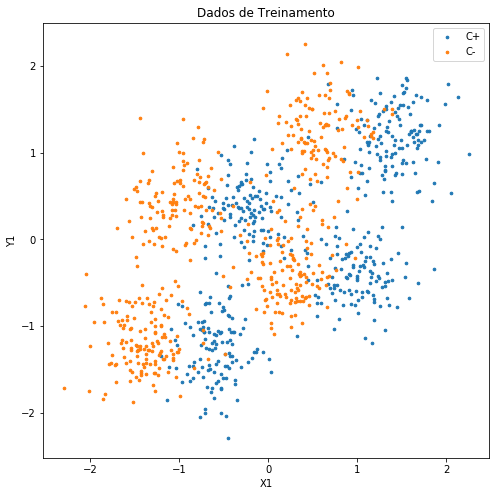

In [279]:
colors = ['red', 'blue']
fig = plt.figure(figsize=(8,8))

label_plus_1 = y_training == 1
label_minus_1 = y_training == -1

x_training_plus_1 = x_training[np.squeeze(label_plus_1), :]
x_training_minus_1 = x_training[np.squeeze(label_minus_1), :]

plt.scatter(x_training_plus_1[:, 0], x_training_plus_1[:, 1], label='C+', s=7)
plt.scatter(x_training_minus_1[:, 0], x_training_minus_1[:, 1], label='C-', s=7)

plt.xlabel('X1')
plt.ylabel('Y1')
plt.title('Dados de Treinamento')
plt.legend()

plt.savefig('training_data.png')

In [280]:
#Training using the MLP
number_of_neurons = np.arange(2, 50)
y_validation_prediction = np.zeros((len(x_validation[:, 0]), len(number_of_neurons)))
validation_f1 = np.zeros(len(number_of_neurons))

i_pred = 0
for i in number_of_neurons:
    clf = MLPClassifier(solver='lbfgs', alpha=0, hidden_layer_sizes=i, random_state=1, 
                        activation='relu', max_iter=300000)
    clf.fit(x_training, np.squeeze(y_training))
    
    #Evaluating the MLP for the ith number of neurons
    y_validation_prediction[:, i_pred] = clf.predict(x_validation)
    
    #Calculating the F1-Score
    validation_f1[i_pred] = f1_score(y_validation, y_validation_prediction[:, i_pred])
    
    i_pred += 1

Maximum F1 score value: 0.881159420289855
Number of neurons which maximize the F1 score: [27]


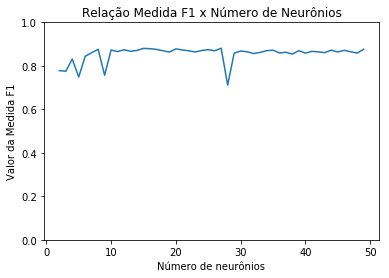

In [281]:
plt.plot(number_of_neurons, validation_f1)
plt.xlabel('Número de neurônios')
plt.ylabel('Valor da Medida F1')
plt.ylim((0, 1))
plt.title('Relação Medida F1 x Número de Neurônios')
print("Maximum F1 score value: " + str(max(validation_f1)))
best_neuron_number = np.where(validation_f1 == max(validation_f1))[0]+2
print("Number of neurons which maximize the F1 score: " + str(best_neuron_number))

plt.savefig('Medida_f1_numero_neuronios.png')

In [282]:
def plot_learning_curve_mlp(title, X_training, y_training, X_validation, y_validation, maxiter=300, 
                            best_nn=50):
    plt.figure()
    plt.title(title)

    plt.xlabel("Iterações")
    plt.ylabel("Função de Custo")
    plt.ylim((0, 1))
    
    loss_training = []
    loss_validation = []
    
    best_MLP_training = MLPClassifier(solver='lbfgs', alpha=0, hidden_layer_sizes=best_nn, random_state=1, 
                                      activation='relu', max_iter=1, warm_start=True)
    best_MLP_validation = MLPClassifier(solver='lbfgs', alpha=0, hidden_layer_sizes=best_nn, random_state=1, 
                                      activation='relu', max_iter=1, warm_start=True)
    
    for i in range(maxiter):
        best_MLP_training.fit(X_training, y_training)
        best_MLP_validation.fit(X_validation, y_validation)
        loss_training.append(best_MLP_training.loss_)
        loss_validation.append(best_MLP_validation.loss_)
          
    plt.plot(loss_training, color="r", label="Training Loss")
    plt.plot(loss_validation, color="g", label="Validation Loss")

    plt.legend(loc="best")
    return plt

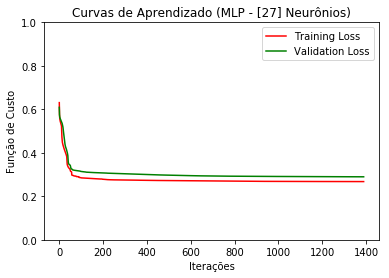

In [283]:
#Plotting the learning curve
#x_training_validation = np.concatenate((x_training, x_validation), axis=0)
#y_training_validation = np.concatenate((y_training, y_validation), axis=0)

best_MLP = MLPClassifier(solver='lbfgs', alpha=0, hidden_layer_sizes=best_neuron_number, random_state=1, 
                         activation='relu', max_iter=300000)

#kf = KFold(n_splits=2)
title = "Curvas de Aprendizado (MLP - " + str(best_neuron_number) + " Neurônios)"
best_MLP.fit(x_training, np.squeeze(y_training))

plot_learning_curve_mlp(title, x_training, np.squeeze(y_training), x_validation, np.squeeze(y_validation), 
                        best_MLP.n_iter_, best_neuron_number)

plt.savefig('Curva_aprendizado_MLP.png')

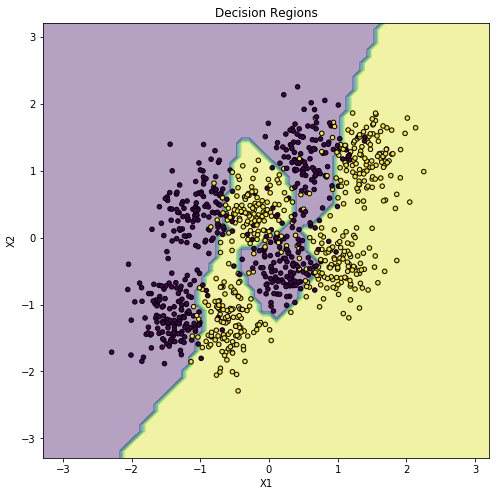

In [284]:
#Plotting the decision region
# Plotting decision regions
x_min, x_max = x_training[:, 0].min() - 1, x_training[:, 0].max() + 1
y_min, y_max = x_training[:, 1].min() - 1, x_training[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

Z = best_MLP.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax.contourf(xx, yy, Z, alpha=0.4)
ax.scatter(x_training[:, 0], x_training[:, 1], c=np.squeeze(y_training), s=20, edgecolor='k')
ax.set_title("Decision Regions")
ax.set_xlabel('X1')
ax.set_ylabel('X2')

plt.show()

fig.savefig('Regiao_decisao_MLP')

In [285]:
y_test_prediction = best_MLP.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_prediction)
print("Error Rate in the Test Set: " + str(1-test_accuracy))

Error Rate in the Test Set: 0.123


## SVM

In [286]:
#Training using the MLP
C_list = np.linspace(0.1, 10, 100)
y_validation_prediction = np.zeros((len(x_validation[:, 0]), len(C_list)))
validation_f1 = np.zeros(len(C_list))

i_pred = 0
for i in C_list:
    clf = SVC(C=i, kernel='rbf', gamma='auto')
    clf.fit(x_training, np.squeeze(y_training))
    
    #Evaluating the SVM for the ith number of neurons
    y_validation_prediction[:, i_pred] = clf.predict(x_validation)
    
    #Calculating the F1-Score
    validation_f1[i_pred] = f1_score(y_validation, y_validation_prediction[:, i_pred])
    
    i_pred += 1

Maximum F1 score value: 0.8668610301263362
Number of neurons which maximize the F1 score: [9.4]


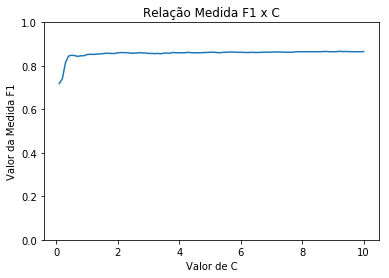

In [287]:
plt.plot(C_list, validation_f1)
plt.xlabel('Valor de C')
plt.ylabel('Valor da Medida F1')
plt.ylim((0, 1))
print("Maximum F1 score value: " + str(max(validation_f1)))
best_C = np.where(validation_f1 == max(validation_f1))[0]+2
print("Number of neurons which maximize the F1 score: " + str(best_C/10+0.1))

plt.title('Relação Medida F1 x C')

plt.savefig('Medida_f1_C_gaussiano.png')

In [288]:
best_SVM = SVC(C=best_C, kernel='rbf', gamma='auto')
best_SVM.fit(x_training, np.squeeze(y_training))

SVC(C=array([93]), cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

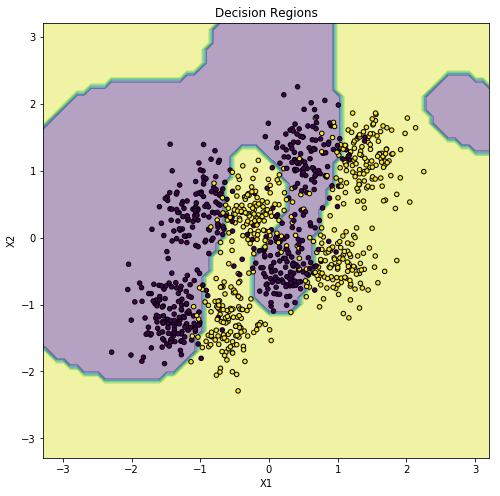

In [289]:
#Plotting the decision region
# Plotting decision regions
x_min, x_max = x_training[:, 0].min() - 1, x_training[:, 0].max() + 1
y_min, y_max = x_training[:, 1].min() - 1, x_training[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

Z = best_SVM.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax.contourf(xx, yy, Z, alpha=0.4)
ax.scatter(x_training[:, 0], x_training[:, 1], c=np.squeeze(y_training), s=20, edgecolor='k')
ax.set_title("Decision Regions")
ax.set_xlabel('X1')
ax.set_ylabel('X2')

plt.show()

fig.savefig('Regiao_Decisao_SVM.png')

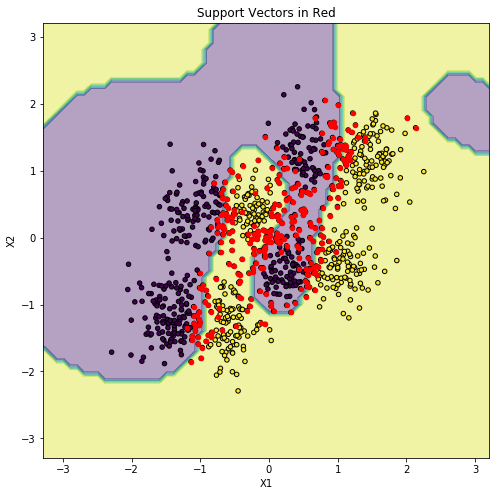

In [290]:
#Plotting the Support Vectors
x_min, x_max = x_training[:, 0].min() - 1, x_training[:, 0].max() + 1
y_min, y_max = x_training[:, 1].min() - 1, x_training[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

Z = best_SVM.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax.contourf(xx, yy, Z, alpha=0.4)
ax.scatter(x_training[:, 0], x_training[:, 1], c=np.squeeze(y_training), s=20, edgecolor='k')
ax.scatter(best_SVM.support_vectors_[:, 0], best_SVM.support_vectors_[:, 1], s=20, c='red')
ax.set_title("Support Vectors in Red")
ax.set_xlabel('X1')
ax.set_ylabel('X2')

plt.show()

fig.savefig('Vetores_Suporte.png')

In [291]:
y_test_prediction = best_SVM.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_prediction)
print("Error Rate in the Test Set: " + str(1-test_accuracy))

Error Rate in the Test Set: 0.125


### SVM - polynomial 

In [292]:
#Training using the MLP
C_list = np.linspace(0.1, 10, 100)
y_validation_prediction = np.zeros((len(x_validation[:, 0]), len(C_list)))
validation_f1 = np.zeros(len(C_list))

i_pred = 0
for i in C_list:
    clf = SVC(C=i, kernel='poly', gamma='auto')
    clf.fit(x_training, np.squeeze(y_training))
    
    #Evaluating the SVM for the ith number of neurons
    y_validation_prediction[:, i_pred] = clf.predict(x_validation)
    
    #Calculating the F1-Score
    validation_f1[i_pred] = f1_score(y_validation, y_validation_prediction[:, i_pred])
    
    i_pred += 1

Maximum F1 score value: 0.7311827956989246
Number of neurons which maximize the F1 score: [ 5.9  6.5  6.6  6.7  6.8  6.9  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7
  7.8  7.9  8.   8.1  8.2  8.9  9.7  9.8  9.9 10.  10.1 10.2]


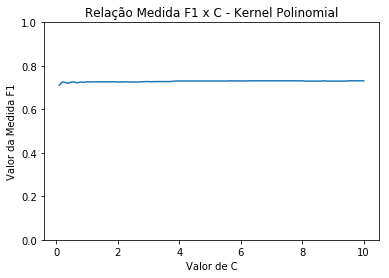

In [293]:
plt.plot(C_list, validation_f1)
plt.xlabel('Valor de C')
plt.ylabel('Valor da Medida F1')
plt.ylim((0, 1))
print("Maximum F1 score value: " + str(max(validation_f1)))
best_C = np.where(validation_f1 == max(validation_f1))[0]+2
print("Number of neurons which maximize the F1 score: " + str(best_C/10+0.1))
plt.title('Relação Medida F1 x C - Kernel Polinomial')

plt.savefig('Medida_f1_C_polinomial.png')